In [1]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import math

from meep.materials import Ag

In [2]:
fontlabel = 16

lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.7       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수
df = fmax-fmin         # 주파수 대역폭

resolution = 50        # 시뮬레이션 해상도
nfreq = 1             # 추출할 주파수 개수
design_region_resolution = 50

In [21]:
tag_bot         = 0.5
tag_side        = 4
tsio2           = 4
tdesignregion   = 1
monitor_position =  1 / fcen*2
monitor_blank   = 1 / fcen * 0.1

tpml = 0.4

width_ag = 0.2
width_sio2 = 2

width_bot_ag = width_ag+width_sio2+width_ag

design_region_width = round(width_bot_ag, 3)
design_region_height = 1

Sx = tpml+width_bot_ag+tpml
Sy = tag_bot+tag_side+tdesignregion+monitor_position+monitor_blank+tpml

SiO2 = mp.Medium(index = 1.45)
TiO2 = mp.Medium(index = 2.6)

Nx = int(design_region_resolution * design_region_width) + 1
Ny = int(design_region_resolution * design_region_height) + 1

y_bottom = -Sy/2
center_y_ag = y_bottom + tag_bot / 2
center_y_sio2 = y_bottom + tag_bot + tsio2 / 2
center_y_design = y_bottom + tag_bot + tsio2 + design_region_height / 2
center_y_monitor_position = y_bottom + tag_bot + tsio2 + design_region_height + monitor_position
center_y_source_position = y_bottom + tag_bot + 1/fcen 
center_Ag_x_position = design_region_width/2-width_ag/2 #+ tpml/2

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), TiO2, SiO2,  grid_type="U_MEAN")

design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(0, center_y_design, 0),
        size=mp.Vector3(design_region_width, design_region_height, 0),
    ),
)


boundary_layers = [mp.Absorber(tpml,direction=mp.X),
                   mp.PML(tpml,direction=mp.Y,side=mp.High)]

In [22]:
cell_size = mp.Vector3(Sx, Sy)
geometry = [
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_bot_ag, tag_bot, 0),
        center=mp.Vector3(0, center_y_ag, 0)
    ),
    mp.Block(
        material=SiO2,
        size=mp.Vector3(width_sio2, tsio2, 0),
        center=mp.Vector3(0, center_y_sio2, 0)
    ),
    mp.Block(
        material=design_variables,
        size=mp.Vector3(design_region_width, design_region_height, 0),
        center=mp.Vector3(0, center_y_design, 0)
    ),

    ######### Side metal ########## 
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(-center_Ag_x_position, center_y_sio2, 0)
    ),
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(center_Ag_x_position, center_y_sio2, 0)
    ),
]

In [23]:
src = mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True)

sources = mp.Source(
            src,
            component=mp.Ez,
            center=mp.Vector3(
                0,
                center_y_source_position,  # Alq3 층의 중간 높이
                0
            )
        )


sim = mp.Simulation(
    resolution=resolution,
    sources=[sources],
    cell_size=cell_size,
    boundary_layers=boundary_layers,
    geometry=geometry,
    default_material=mp.Medium(index = 1),
    extra_materials=[Ag]
)

In [24]:
minimum_length = 0.09  # minimum length scale (microns)
eta_i = 0.5  # blueprint (or intermediate) design field thresholding point (between 0 and 1)
eta_e = 0.55  # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e  # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)

def mapping(x, eta, beta):

    return x

     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


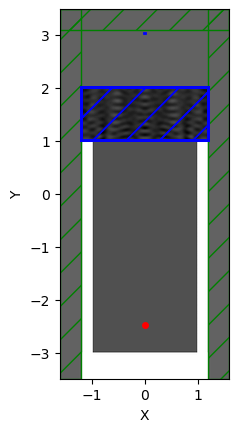

In [56]:
monitor_position, monitor_size = mp.Vector3(0, center_y_monitor_position), mp.Vector3(0.01,0)
FourierFields = mpa.FourierFields(sim,mp.Volume(center=monitor_position,size=monitor_size),mp.Ez,yee_grid=True)
ob_list = [FourierFields]

def J(fields):
    return npa.mean(npa.abs(fields) ** 2) # The index 1 corresponds to the point at the center of our monitor.

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J],
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=[fcen],
    maximum_run_time=100,
)

opt.plot2D(True)

In [26]:
evaluation_history = []
cur_iter = [0]
numevl = 1

def f(v, gradient, beta):
    global numevl
    print("Current iteration : {}".format(cur_iter[0] + 1))

    f0, dJ_du = opt([mapping(v, eta_i, beta)])

    if gradient.size > 0:
        gradient[:] = tensor_jacobian_product(mapping, 0)(
            v, eta_i, beta, np.real(dJ_du).ravel()
        )  # backprop

    evaluation_history.append([np.max(np.real(f0))])
    numevl += 1
    cur_iter[0] = cur_iter[0] + 1

    print("First FOM : {}".format(evaluation_history))
    print("Current f0 value: {}".format(np.real(f0)))

    return np.mean(f0)

In [27]:
algorithm = nlopt.LD_MMA
n = Nx * Ny  # number of parameters

# Initial guess
x = np.ones((n,)) * 0.5

# lower and upper bounds
lb = np.zeros((Nx * Ny,))
ub = np.ones((Nx * Ny,))

cur_beta = 4
beta_scale = 1.5
num_betas = 8
update_factor = 10
ftol = 1e-5
for iters in range(num_betas):
    solver = nlopt.opt(algorithm, n)
    solver.set_lower_bounds(lb)
    solver.set_upper_bounds(ub)
    solver.set_max_objective(lambda a, g: f(a, g, cur_beta))
    solver.set_maxeval(update_factor)
    solver.set_ftol_rel(ftol)
    x[:] = solver.optimize(x)
    cur_beta = cur_beta * beta_scale

Current iteration : 1
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.91006e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.063

run 1 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156]]
Current f0 value: 0.019799039382250156
Current iteration : 2
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
    

run 3 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706]]
Current f0 value: 0.020990981490342706
Current iteration : 3
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center 

run 5 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045]]
Current f0 value: 0.035199665036742045
Current iteration : 4
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.71933e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,

run 7 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616]]
Current f0 value: 0.21618478868635616
Current iteration : 5
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant 

run 9 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705]]
Current f0 value: 0.07773390628892705
Current iteration : 6
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
       

run 11 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207]]
Current f0 value: 0.06485621112067207
Current iteration : 7
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 4.41074e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), 

run 13 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054]]
Current f0 value: 0.465378643666054
Current iteration : 8
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.81334e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
     

run 15 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471]]
Current f0 value: 0.12473197330573471
Current iteration : 9
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.98023e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
     

run 17 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985]]
Current f0 value: 0.46761989937182985
Current iteration : 10
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.98023e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = 

run 19 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235]]
Current f0 value: 0.9301968825420235
Current iteration : 11
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.81334e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)


run 21 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235]]
Current f0 value: 0.9301968825420235
Current iteration : 12
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.19481e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0

run 23 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047]]
Current f0 value: 0.9842316961627047
Current iteration : 13
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.09944e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,

run 25 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546]]
Current f0 value: 1.221817830574546
Current iteration : 14
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.81334e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
  

run 27 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548]]
Current f0 value: 1.4057657445751548
Current iteration : 15
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, ce

run 29 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879]]
Current f0 value: 1.505630840872879
Current iteration : 16
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.09944e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.

run 31 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115]]
Current f0 value: 1.7013449708536115
Current iteration : 17
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagon

run 33 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344]]
Current f0 value: 0.07976677076213344
Current iteration : 18
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.88486e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectri

run 35 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458]]
Current f0 value: 1.653478971422458
Current iteration : 19
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
 

run 37 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633]]
Current f0 value: 1.7517255011052633
Current iteration : 20
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0

run 39 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673]]
Current f0 value: 1.8004950956359673
Current iteration : 21
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4

run 41 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673]]
Current f0 value: 1.8004950956359673
Current iteration : 22
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,

run 43 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994]]
Current f0 value: 1.8204060123577994
Current iteration : 23
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, 

run 45 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736]]
Current f0 value: 1.9804438579995736
Current iteration : 24
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.09944e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal 

run 47 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615]]
Current f0 value: 0.2890808793542615
Current iteration : 25
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.88486e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric cons

run 49 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733]]
Current f0 value: 1.9451691179938733
Current iteration : 26
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
   

run 51 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543]]
Current f0 value: 2.0489238939383543
Current iteration : 27
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 8.60691e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0)

run 53 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543], [1.6749479542863976]]
Current f0 value: 1.6749479542863976
Current iteration : 28
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)


run 55 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543], [1.6749479542863976], [2.114592376461612]]
Current f0 value: 2.114592376461612
Current iteration : 29
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 4.3869e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
        

run 57 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543], [1.6749479542863976], [2.114592376461612], [2.139271400770102]]
Current f0 value: 2.139271400770102
Current iteration : 30
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.88486e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (

run 59 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543], [1.6749479542863976], [2.114592376461612], [2.139271400770102], [2.289848084138884]]
Current f0 value: 2.289848084138884
Current iteration : 31
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.88486e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
 

run 61 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543], [1.6749479542863976], [2.114592376461612], [2.139271400770102], [2.289848084138884], [2.289848084138884]]
Current f0 value: 2.289848084138884
Current iteration : 32
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0

run 63 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543], [1.6749479542863976], [2.114592376461612], [2.139271400770102], [2.289848084138884], [2.289848084138884], [2.3283258124794206]]
Current f0 value: 2.3283258124794206
Current iteration : 33
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.19481e-05 s
Working in 2D dimensions.
Computational

run 65 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543], [1.6749479542863976], [2.114592376461612], [2.139271400770102], [2.289848084138884], [2.289848084138884], [2.3283258124794206], [2.4391876669266632]]
Current f0 value: 2.4391876669266632
Current iteration : 34
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 2D dim

run 67 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543], [1.6749479542863976], [2.114592376461612], [2.139271400770102], [2.289848084138884], [2.289848084138884], [2.3283258124794206], [2.4391876669266632], [0.16994499400039442]]
Current f0 value: 0.16994499400039442
Current iteration : 35
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e

run 69 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543], [1.6749479542863976], [2.114592376461612], [2.139271400770102], [2.289848084138884], [2.289848084138884], [2.3283258124794206], [2.4391876669266632], [0.16994499400039442], [1.5740719777251604]]
Current f0 value: 1.5740719777251604
Current iteration : 36
Starting forward run...
-----------
Initializing structure...
time for choose_ch

run 71 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543], [1.6749479542863976], [2.114592376461612], [2.139271400770102], [2.289848084138884], [2.289848084138884], [2.3283258124794206], [2.4391876669266632], [0.16994499400039442], [1.5740719777251604], [2.4454542461271203]]
Current f0 value: 2.4454542461271203
Current iteration : 37
Starting forward run...
-----------
Initializing structure

run 73 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543], [1.6749479542863976], [2.114592376461612], [2.139271400770102], [2.289848084138884], [2.289848084138884], [2.3283258124794206], [2.4391876669266632], [0.16994499400039442], [1.5740719777251604], [2.4454542461271203], [2.4949205713627207]]
Current f0 value: 2.4949205713627207
Current iteration : 38
Starting forward run...
-----------


run 75 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543], [1.6749479542863976], [2.114592376461612], [2.139271400770102], [2.289848084138884], [2.289848084138884], [2.3283258124794206], [2.4391876669266632], [0.16994499400039442], [1.5740719777251604], [2.4454542461271203], [2.4949205713627207], [2.5859692075813685]]
Current f0 value: 2.5859692075813685
Current iteration : 39
Starting forwa

run 77 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543], [1.6749479542863976], [2.114592376461612], [2.139271400770102], [2.289848084138884], [2.289848084138884], [2.3283258124794206], [2.4391876669266632], [0.16994499400039442], [1.5740719777251604], [2.4454542461271203], [2.4949205713627207], [2.5859692075813685], [0.7949105034039136]]
Current f0 value: 0.7949105034039136
Current iterati

run 79 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543], [1.6749479542863976], [2.114592376461612], [2.139271400770102], [2.289848084138884], [2.289848084138884], [2.3283258124794206], [2.4391876669266632], [0.16994499400039442], [1.5740719777251604], [2.4454542461271203], [2.4949205713627207], [2.5859692075813685], [0.7949105034039136], [2.622486608246314]]
Current f0 value: 2.62248660824

run 81 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543], [1.6749479542863976], [2.114592376461612], [2.139271400770102], [2.289848084138884], [2.289848084138884], [2.3283258124794206], [2.4391876669266632], [0.16994499400039442], [1.5740719777251604], [2.4454542461271203], [2.4949205713627207], [2.5859692075813685], [0.7949105034039136], [2.622486608246314], [2.622486608246314]]
Current f0

run 83 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543], [1.6749479542863976], [2.114592376461612], [2.139271400770102], [2.289848084138884], [2.289848084138884], [2.3283258124794206], [2.4391876669266632], [0.16994499400039442], [1.5740719777251604], [2.4454542461271203], [2.4949205713627207], [2.5859692075813685], [0.7949105034039136], [2.622486608246314], [2.622486608246314], [2.6774476

run 85 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543], [1.6749479542863976], [2.114592376461612], [2.139271400770102], [2.289848084138884], [2.289848084138884], [2.3283258124794206], [2.4391876669266632], [0.16994499400039442], [1.5740719777251604], [2.4454542461271203], [2.4949205713627207], [2.5859692075813685], [0.7949105034039136], [2.622486608246314], [2.622486608246314], [2.6774476

run 87 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543], [1.6749479542863976], [2.114592376461612], [2.139271400770102], [2.289848084138884], [2.289848084138884], [2.3283258124794206], [2.4391876669266632], [0.16994499400039442], [1.5740719777251604], [2.4454542461271203], [2.4949205713627207], [2.5859692075813685], [0.7949105034039136], [2.622486608246314], [2.622486608246314], [2.6774476

run 89 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543], [1.6749479542863976], [2.114592376461612], [2.139271400770102], [2.289848084138884], [2.289848084138884], [2.3283258124794206], [2.4391876669266632], [0.16994499400039442], [1.5740719777251604], [2.4454542461271203], [2.4949205713627207], [2.5859692075813685], [0.7949105034039136], [2.622486608246314], [2.622486608246314], [2.6774476

run 91 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543], [1.6749479542863976], [2.114592376461612], [2.139271400770102], [2.289848084138884], [2.289848084138884], [2.3283258124794206], [2.4391876669266632], [0.16994499400039442], [1.5740719777251604], [2.4454542461271203], [2.4949205713627207], [2.5859692075813685], [0.7949105034039136], [2.622486608246314], [2.622486608246314], [2.6774476

run 93 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543], [1.6749479542863976], [2.114592376461612], [2.139271400770102], [2.289848084138884], [2.289848084138884], [2.3283258124794206], [2.4391876669266632], [0.16994499400039442], [1.5740719777251604], [2.4454542461271203], [2.4949205713627207], [2.5859692075813685], [0.7949105034039136], [2.622486608246314], [2.622486608246314], [2.6774476

run 95 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543], [1.6749479542863976], [2.114592376461612], [2.139271400770102], [2.289848084138884], [2.289848084138884], [2.3283258124794206], [2.4391876669266632], [0.16994499400039442], [1.5740719777251604], [2.4454542461271203], [2.4949205713627207], [2.5859692075813685], [0.7949105034039136], [2.622486608246314], [2.622486608246314], [2.6774476

run 97 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543], [1.6749479542863976], [2.114592376461612], [2.139271400770102], [2.289848084138884], [2.289848084138884], [2.3283258124794206], [2.4391876669266632], [0.16994499400039442], [1.5740719777251604], [2.4454542461271203], [2.4949205713627207], [2.5859692075813685], [0.7949105034039136], [2.622486608246314], [2.622486608246314], [2.6774476

run 99 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543], [1.6749479542863976], [2.114592376461612], [2.139271400770102], [2.289848084138884], [2.289848084138884], [2.3283258124794206], [2.4391876669266632], [0.16994499400039442], [1.5740719777251604], [2.4454542461271203], [2.4949205713627207], [2.5859692075813685], [0.7949105034039136], [2.622486608246314], [2.622486608246314], [2.6774476

run 101 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543], [1.6749479542863976], [2.114592376461612], [2.139271400770102], [2.289848084138884], [2.289848084138884], [2.3283258124794206], [2.4391876669266632], [0.16994499400039442], [1.5740719777251604], [2.4454542461271203], [2.4949205713627207], [2.5859692075813685], [0.7949105034039136], [2.622486608246314], [2.622486608246314], [2.677447

run 103 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543], [1.6749479542863976], [2.114592376461612], [2.139271400770102], [2.289848084138884], [2.289848084138884], [2.3283258124794206], [2.4391876669266632], [0.16994499400039442], [1.5740719777251604], [2.4454542461271203], [2.4949205713627207], [2.5859692075813685], [0.7949105034039136], [2.622486608246314], [2.622486608246314], [2.677447

run 105 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543], [1.6749479542863976], [2.114592376461612], [2.139271400770102], [2.289848084138884], [2.289848084138884], [2.3283258124794206], [2.4391876669266632], [0.16994499400039442], [1.5740719777251604], [2.4454542461271203], [2.4949205713627207], [2.5859692075813685], [0.7949105034039136], [2.622486608246314], [2.622486608246314], [2.677447

run 107 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543], [1.6749479542863976], [2.114592376461612], [2.139271400770102], [2.289848084138884], [2.289848084138884], [2.3283258124794206], [2.4391876669266632], [0.16994499400039442], [1.5740719777251604], [2.4454542461271203], [2.4949205713627207], [2.5859692075813685], [0.7949105034039136], [2.622486608246314], [2.622486608246314], [2.677447

run 109 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543], [1.6749479542863976], [2.114592376461612], [2.139271400770102], [2.289848084138884], [2.289848084138884], [2.3283258124794206], [2.4391876669266632], [0.16994499400039442], [1.5740719777251604], [2.4454542461271203], [2.4949205713627207], [2.5859692075813685], [0.7949105034039136], [2.622486608246314], [2.622486608246314], [2.677447

run 111 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543], [1.6749479542863976], [2.114592376461612], [2.139271400770102], [2.289848084138884], [2.289848084138884], [2.3283258124794206], [2.4391876669266632], [0.16994499400039442], [1.5740719777251604], [2.4454542461271203], [2.4949205713627207], [2.5859692075813685], [0.7949105034039136], [2.622486608246314], [2.622486608246314], [2.677447

run 113 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543], [1.6749479542863976], [2.114592376461612], [2.139271400770102], [2.289848084138884], [2.289848084138884], [2.3283258124794206], [2.4391876669266632], [0.16994499400039442], [1.5740719777251604], [2.4454542461271203], [2.4949205713627207], [2.5859692075813685], [0.7949105034039136], [2.622486608246314], [2.622486608246314], [2.677447

run 115 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543], [1.6749479542863976], [2.114592376461612], [2.139271400770102], [2.289848084138884], [2.289848084138884], [2.3283258124794206], [2.4391876669266632], [0.16994499400039442], [1.5740719777251604], [2.4454542461271203], [2.4949205713627207], [2.5859692075813685], [0.7949105034039136], [2.622486608246314], [2.622486608246314], [2.677447

run 117 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543], [1.6749479542863976], [2.114592376461612], [2.139271400770102], [2.289848084138884], [2.289848084138884], [2.3283258124794206], [2.4391876669266632], [0.16994499400039442], [1.5740719777251604], [2.4454542461271203], [2.4949205713627207], [2.5859692075813685], [0.7949105034039136], [2.622486608246314], [2.622486608246314], [2.677447

run 119 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543], [1.6749479542863976], [2.114592376461612], [2.139271400770102], [2.289848084138884], [2.289848084138884], [2.3283258124794206], [2.4391876669266632], [0.16994499400039442], [1.5740719777251604], [2.4454542461271203], [2.4949205713627207], [2.5859692075813685], [0.7949105034039136], [2.622486608246314], [2.622486608246314], [2.677447

run 121 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543], [1.6749479542863976], [2.114592376461612], [2.139271400770102], [2.289848084138884], [2.289848084138884], [2.3283258124794206], [2.4391876669266632], [0.16994499400039442], [1.5740719777251604], [2.4454542461271203], [2.4949205713627207], [2.5859692075813685], [0.7949105034039136], [2.622486608246314], [2.622486608246314], [2.677447

run 123 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543], [1.6749479542863976], [2.114592376461612], [2.139271400770102], [2.289848084138884], [2.289848084138884], [2.3283258124794206], [2.4391876669266632], [0.16994499400039442], [1.5740719777251604], [2.4454542461271203], [2.4949205713627207], [2.5859692075813685], [0.7949105034039136], [2.622486608246314], [2.622486608246314], [2.677447

run 125 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543], [1.6749479542863976], [2.114592376461612], [2.139271400770102], [2.289848084138884], [2.289848084138884], [2.3283258124794206], [2.4391876669266632], [0.16994499400039442], [1.5740719777251604], [2.4454542461271203], [2.4949205713627207], [2.5859692075813685], [0.7949105034039136], [2.622486608246314], [2.622486608246314], [2.677447

run 127 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543], [1.6749479542863976], [2.114592376461612], [2.139271400770102], [2.289848084138884], [2.289848084138884], [2.3283258124794206], [2.4391876669266632], [0.16994499400039442], [1.5740719777251604], [2.4454542461271203], [2.4949205713627207], [2.5859692075813685], [0.7949105034039136], [2.622486608246314], [2.622486608246314], [2.677447

run 129 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543], [1.6749479542863976], [2.114592376461612], [2.139271400770102], [2.289848084138884], [2.289848084138884], [2.3283258124794206], [2.4391876669266632], [0.16994499400039442], [1.5740719777251604], [2.4454542461271203], [2.4949205713627207], [2.5859692075813685], [0.7949105034039136], [2.622486608246314], [2.622486608246314], [2.677447

run 131 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543], [1.6749479542863976], [2.114592376461612], [2.139271400770102], [2.289848084138884], [2.289848084138884], [2.3283258124794206], [2.4391876669266632], [0.16994499400039442], [1.5740719777251604], [2.4454542461271203], [2.4949205713627207], [2.5859692075813685], [0.7949105034039136], [2.622486608246314], [2.622486608246314], [2.677447

run 133 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543], [1.6749479542863976], [2.114592376461612], [2.139271400770102], [2.289848084138884], [2.289848084138884], [2.3283258124794206], [2.4391876669266632], [0.16994499400039442], [1.5740719777251604], [2.4454542461271203], [2.4949205713627207], [2.5859692075813685], [0.7949105034039136], [2.622486608246314], [2.622486608246314], [2.677447

run 135 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543], [1.6749479542863976], [2.114592376461612], [2.139271400770102], [2.289848084138884], [2.289848084138884], [2.3283258124794206], [2.4391876669266632], [0.16994499400039442], [1.5740719777251604], [2.4454542461271203], [2.4949205713627207], [2.5859692075813685], [0.7949105034039136], [2.622486608246314], [2.622486608246314], [2.677447

run 137 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543], [1.6749479542863976], [2.114592376461612], [2.139271400770102], [2.289848084138884], [2.289848084138884], [2.3283258124794206], [2.4391876669266632], [0.16994499400039442], [1.5740719777251604], [2.4454542461271203], [2.4949205713627207], [2.5859692075813685], [0.7949105034039136], [2.622486608246314], [2.622486608246314], [2.677447

run 139 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543], [1.6749479542863976], [2.114592376461612], [2.139271400770102], [2.289848084138884], [2.289848084138884], [2.3283258124794206], [2.4391876669266632], [0.16994499400039442], [1.5740719777251604], [2.4454542461271203], [2.4949205713627207], [2.5859692075813685], [0.7949105034039136], [2.622486608246314], [2.622486608246314], [2.677447

run 141 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543], [1.6749479542863976], [2.114592376461612], [2.139271400770102], [2.289848084138884], [2.289848084138884], [2.3283258124794206], [2.4391876669266632], [0.16994499400039442], [1.5740719777251604], [2.4454542461271203], [2.4949205713627207], [2.5859692075813685], [0.7949105034039136], [2.622486608246314], [2.622486608246314], [2.677447

run 143 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543], [1.6749479542863976], [2.114592376461612], [2.139271400770102], [2.289848084138884], [2.289848084138884], [2.3283258124794206], [2.4391876669266632], [0.16994499400039442], [1.5740719777251604], [2.4454542461271203], [2.4949205713627207], [2.5859692075813685], [0.7949105034039136], [2.622486608246314], [2.622486608246314], [2.677447

run 145 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543], [1.6749479542863976], [2.114592376461612], [2.139271400770102], [2.289848084138884], [2.289848084138884], [2.3283258124794206], [2.4391876669266632], [0.16994499400039442], [1.5740719777251604], [2.4454542461271203], [2.4949205713627207], [2.5859692075813685], [0.7949105034039136], [2.622486608246314], [2.622486608246314], [2.677447

run 147 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543], [1.6749479542863976], [2.114592376461612], [2.139271400770102], [2.289848084138884], [2.289848084138884], [2.3283258124794206], [2.4391876669266632], [0.16994499400039442], [1.5740719777251604], [2.4454542461271203], [2.4949205713627207], [2.5859692075813685], [0.7949105034039136], [2.622486608246314], [2.622486608246314], [2.677447

run 149 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543], [1.6749479542863976], [2.114592376461612], [2.139271400770102], [2.289848084138884], [2.289848084138884], [2.3283258124794206], [2.4391876669266632], [0.16994499400039442], [1.5740719777251604], [2.4454542461271203], [2.4949205713627207], [2.5859692075813685], [0.7949105034039136], [2.622486608246314], [2.622486608246314], [2.677447

run 151 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543], [1.6749479542863976], [2.114592376461612], [2.139271400770102], [2.289848084138884], [2.289848084138884], [2.3283258124794206], [2.4391876669266632], [0.16994499400039442], [1.5740719777251604], [2.4454542461271203], [2.4949205713627207], [2.5859692075813685], [0.7949105034039136], [2.622486608246314], [2.622486608246314], [2.677447

run 153 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543], [1.6749479542863976], [2.114592376461612], [2.139271400770102], [2.289848084138884], [2.289848084138884], [2.3283258124794206], [2.4391876669266632], [0.16994499400039442], [1.5740719777251604], [2.4454542461271203], [2.4949205713627207], [2.5859692075813685], [0.7949105034039136], [2.622486608246314], [2.622486608246314], [2.677447

run 155 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543], [1.6749479542863976], [2.114592376461612], [2.139271400770102], [2.289848084138884], [2.289848084138884], [2.3283258124794206], [2.4391876669266632], [0.16994499400039442], [1.5740719777251604], [2.4454542461271203], [2.4949205713627207], [2.5859692075813685], [0.7949105034039136], [2.622486608246314], [2.622486608246314], [2.677447

run 157 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342706], [0.035199665036742045], [0.21618478868635616], [0.07773390628892705], [0.06485621112067207], [0.465378643666054], [0.12473197330573471], [0.46761989937182985], [0.9301968825420235], [0.9301968825420235], [0.9842316961627047], [1.221817830574546], [1.4057657445751548], [1.505630840872879], [1.7013449708536115], [0.07976677076213344], [1.653478971422458], [1.7517255011052633], [1.8004950956359673], [1.8004950956359673], [1.8204060123577994], [1.9804438579995736], [0.2890808793542615], [1.9451691179938733], [2.0489238939383543], [1.6749479542863976], [2.114592376461612], [2.139271400770102], [2.289848084138884], [2.289848084138884], [2.3283258124794206], [2.4391876669266632], [0.16994499400039442], [1.5740719777251604], [2.4454542461271203], [2.4949205713627207], [2.5859692075813685], [0.7949105034039136], [2.622486608246314], [2.622486608246314], [2.677447

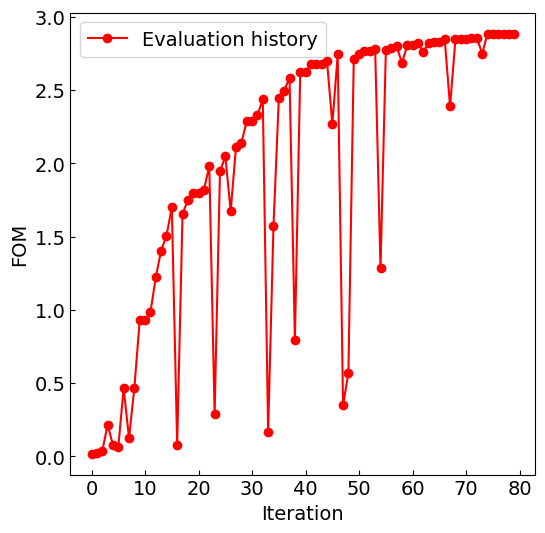

In [49]:
plt.figure(figsize = (6,6))

plt.plot(evaluation_history, 'or-',   label='Evaluation history',)

plt.xlabel('Iteration',fontsize = 14)
plt.ylabel('FOM',fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

# plt.title('Optimization', fontsize = 16)
plt.tick_params(direction = 'in')

plt.legend( fontsize = 14,)

plt.show()

In [ ]:
# np.savetxt("LD_MMA_2lambda_pos.txt", design_variables.weights)

In [72]:
import numpy as np

data = np.loadtxt('LD_MMA_2lambda_pos.txt')

print("Loaded array shape:", data.shape)

opt.update_design([data])


Loaded array shape: (6171,)


In [73]:
print('Min : ', min(data))
print('Max : ',max(data))

Min :  0.0004812825031665371
Max :  0.9794625541730333


     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


(-1.2, 1.2, 1.0154545454545456, 2.0154545454545456)

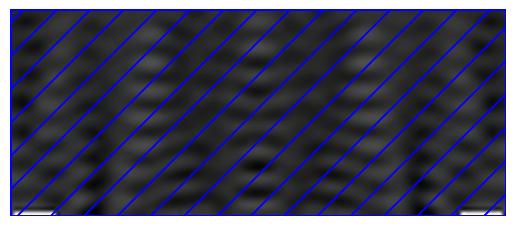

In [90]:
opt.plot2D(
    True,
    output_plane = mp.Volume(size = design_region.size, center = design_region.center),
    
    plot_sources_flag=False,
    plot_monitors_flag=False,
    plot_boundaries_flag=False,
)
plt.axis(False)

     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)


          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


<Axes: xlabel='X', ylabel='Y'>

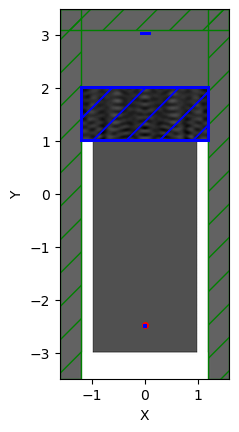

In [93]:
# opt.update_design([data])

offset = 0.01
flux_size = 0.02
mn_size = 0.3*1/fcen
# mn_size = 2
monitor_position_y, monitor_size = mp.Vector3(0, center_y_monitor_position), mp.Vector3(mn_size,0,0)

#### input source의 flux ####
input_flux = opt.sim.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(center=sources.center - mp.Vector3(offset, 0, 0),
                    size=mp.Vector3(0, flux_size),
                    # direction=mp.X, 
                    weight=-1),
        mp.FluxRegion(center=sources.center + mp.Vector3(offset, 0, 0),
                    size=mp.Vector3(0, flux_size),
                    # direction=mp.X
                    ),
        mp.FluxRegion(center=sources.center - mp.Vector3(0, offset, 0),
                    size=mp.Vector3(flux_size, 0),
                    # direction=mp.Y, 
                    weight=-1),
        mp.FluxRegion(center=sources.center + mp.Vector3(0, offset, 0),
                    size=mp.Vector3(flux_size, 0),
                    # direction=mp.Y
                    )
    )

#### output flux -> add flux로 계산한 poynting vector ####
out_flux = opt.sim.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(
                center=monitor_position_y,
                size=monitor_size,
                # direction=mp.Y
        )
    )

#### output flux -> 성분별 field를 뽑고, poynting vector를 계산할 예정 ####
dft_fields = opt.sim.add_dft_fields([mp.Ex, mp.Ey, mp.Ez, mp.Hx, mp.Hy, mp.Hz], fcen, 0, 1, 
                                    center = monitor_position_y,
                                    size = monitor_size, 
                                    yee_grid=True)

opt.sim.plot2D()

In [ ]:
sim.run(until_after_sources=mp.stop_when_fields_decayed(30, mp.Ez, sources.center, 1e-3))

field decay(t = 30.01): 27.717833220969734 / 27.717833220969734 = 1.0
field decay(t = 60.02): 0.6721990181626342 / 27.717833220969734 = 0.024251499487849097
field decay(t = 90.03): 0.262453219390578 / 27.717833220969734 = 0.009468749497778954
field decay(t = 120.04): 0.07368811541677908 / 27.717833220969734 = 0.002658509228673432
on time step 13531 (time=135.31), 0.000295623 s/step
field decay(t = 150.05): 0.029656783189465515 / 27.717833220969734 = 0.0010699531580639168
field decay(t = 180.06): 0.009680624066803757 / 27.717833220969734 = 0.00034925616261663445
run 167 finished at t = 180.06 (18006 timesteps)


     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


<Axes: xlabel='X', ylabel='Y'>

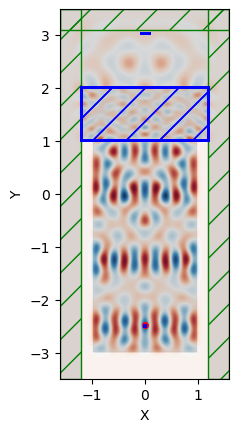

In [95]:
opt.sim.plot2D(fields = mp.Ez,
    #     field_parameters={
    #     'cmap': 'magma',    # magma 컬러맵 지정
    #     'alpha': 1,       # 필드 투명도 (0.0~1.0)
    #     'interpolation': 'none'
    # },
)

/home/min/miniconda3/envs/mp/lib/python3.9/site-packages/meep/visualization.py:284: UserWarning: The specified user volume is larger than the simulation domain and has been truncated.
  warnings.warn(


     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


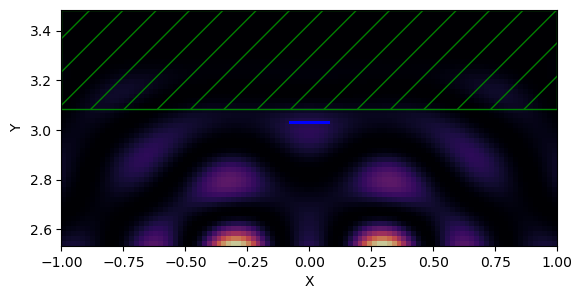

In [104]:
opt.sim.plot2D(
    fields=mp.Ez,
    output_plane=mp.Volume(
    center = monitor_position_y,
    size = mp.Vector3(2, 1)),
    field_parameters={
        'post_process': lambda x: np.abs(x)**2,  # 복소수 필드 x → intensity |x|^2
        'cmap': 'magma',                         # 원하시는 colormap
        'alpha': 0.8,                            # 투명도
        'interpolation': 'none'
    },
    eps_parameters={'cmap':'magma','alpha':1}
)
plt.show()

/home/min/miniconda3/envs/mp/lib/python3.9/site-packages/meep/visualization.py:284: UserWarning: The specified user volume is larger than the simulation domain and has been truncated.
  warnings.warn(


     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


<Axes: xlabel='X', ylabel='Y'>

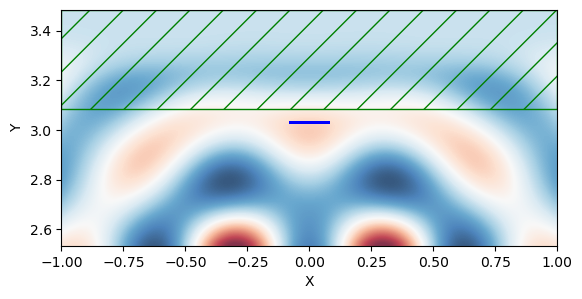

In [ ]:
opt.sim.plot2D(field = mp.Ez, output_plane=mp.Volume(
    center = monitor_position_y,
    size = mp.Vector3(2, 1)
),
    # field_parameters={
    #     'cmap': 'magma',    # magma 컬러맵 지정
    #     'alpha': 1,       # 필드 투명도 (0.0~1.0)
    #     'interpolation': 'none'
    # }
)

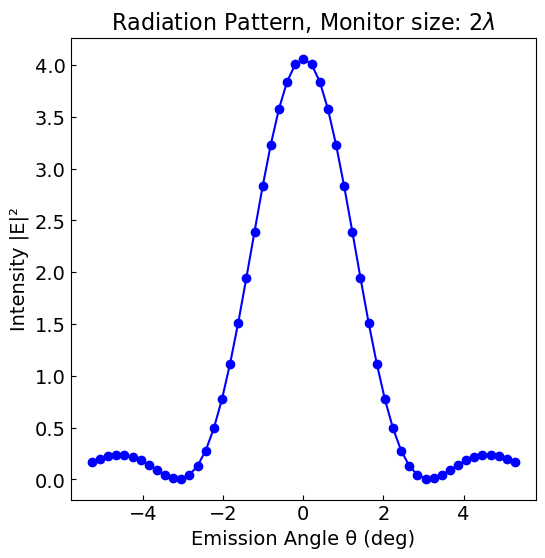

In [89]:
external_field_array = opt.sim.get_dft_array(dft_fields, mp.Ez, 0)

N = len(external_field_array)
W = mn_size                           # μm 단위 모니터 폭
x = np.linspace(-W/2, W/2, N)                     # μm 단위 위치
z = abs(center_y_monitor_position - center_y_source_position)  # μm 단위 거리
theta = np.degrees(np.arctan2(x, z))               # rad → deg 변환

# 3) Intensity 계산
I = np.abs(external_field_array)**2

# 4) θ 축으로 플롯
plt.figure(figsize=(6,6))
plt.plot(theta, I, 'bo-')
plt.xlabel('Emission Angle θ (deg)', fontsize=14)
plt.ylabel('Intensity |E|²',       fontsize=14)
plt.title(r'Radiation Pattern, Monitor size: $2\lambda$', fontsize=16)
plt.tick_params(direction = 'in')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

In [97]:
freq_idx = 0

Ez_hat = sim.get_dft_array(dft_fields, mp.Ez, freq_idx)  
Hx_hat = sim.get_dft_array(dft_fields, mp.Hx, freq_idx)  

Sy_density = np.real(Ez_hat * np.conj(Hx_hat))   

L = float(monitor_size.x)      
N = Sy_density.size            
x = np.linspace(-L/2, L/2, N)  

flux_total = np.round(np.trapz(Sy_density, x)  ,5)
add_flx = np.array(mp.get_fluxes(out_flux))[0]

print(f"DFT monitor 적분으로 구한 total flux = {flux_total}")
print("Add flux로 계산한 total flux = ", add_flx)

err = np.abs((flux_total-add_flx)/add_flx)*100
print("오차율 (%) : ", err, "%")

eqe = np.round(flux_total / np.array(mp.get_fluxes(input_flux))[0] * 100,5)
print("Output flux :", flux_total)
print("Input flux :", np.round(np.array(mp.get_fluxes(input_flux))[0] ,5))
print("EQE(%) :", eqe,"%")

DFT monitor 적분으로 구한 total flux = 0.50423
Add flux로 계산한 total flux =  0.5070550021701338
오차율 (%) :  0.5571391975314613 %
Output flux : 0.50423
Input flux : 0.81469
EQE(%) : 61.89212 %
